In [1]:
import pandas as pd
import matplotlib as mpl
import datetime as dt
import re
from tkinter import *
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

%matplotlib inline

## Defining the IRS Scams Manager Class

The manager class contains functions to prepare our cvs files for discoveries that will answer our research question.

In [2]:
class IRSScamsManager:
    
    name_replace_pat = re.compile(r"[^a-z]+")
    
    # The columns and columns names differed slightly between the
    # two Excel files, so we clean them up here.
    @staticmethod
    def convert_col_names(names):
        return [ re.sub(IRSScamsManager.name_replace_pat, "_", name.lower().strip())
            for name in names ]
    
    @staticmethod
    def rename_cols(df):
        return df.rename(columns=dict(zip(df.columns, IRSScamsManager.convert_col_names(df.columns))))
    
    @staticmethod
    def clean_state_codes(state_name):
        if type(state_name) == str and "|" in state_name:
            non_null = list(filter(lambda x: x != "", state_name.split("|")))
            if len(non_null):
                return non_null[0]
            else:
                return None
        else:
            return state_name

## Loading The Data

The data for this analysis was obtained via a Freedom of Information Act request to the Federal Trade Commission. Originally, the data came in two Excel files, which have been converted to CSVs for the purposes of this analysis.

In [3]:
early_data = IRSScamsManager.rename_cols(pd.read_csv("FTC_2011-43014.csv", encoding = "ISO-8859-1"))
later_data = IRSScamsManager.rename_cols(pd.read_csv("FTC_5114-71014.csv", encoding = "ISO-8859-1"))

In [4]:
df = pd.concat([early_data, later_data], sort=False)

In [5]:
df["created_datetime"] = df["created_date"].apply(lambda x: dt.datetime.strptime(str(x), "%m/%d/%Y") if not pd.isnull(x) else None)

In [6]:
df = df.set_index("created_datetime")

In [7]:
df.head()

,reference_number,created_date,consumer_address_city,consumer_address_state_code,company_name,company_phone_area_code,company_phone_number,company_phone_extension,complaint_info_initial_contact_method,complaint_info_product_service_code
created_datetime,,,,,,,,,,
2011-01-04,28741989,01/04/2011,Waianae,HI,IRS,NaN,NaN,NaN,Phone,2143|9043
2011-01-10,28803726,01/10/2011,Marietta,GA,Georgia State IRS,770,9448020,NaN,Phone,9043
2011-01-12,28827558,01/12/2011,Fort Worth,TX,IRS,872,4796242,NaN,Phone,2142|9043
2011-01-13,28842181,01/13/2011,Orangeburg,SC,IRS,800,8297650,NaN,Phone,9043
2011-01-19,28890200,01/19/2011,Morton,MN,IRS|Readers Digest,876|,4355471|,|,Phone,4190|9043


## Cleaning Up the "Created Date"s and State Codes

A few of the columns in the data sometimes contain `|` to delimit multiple options selected on a complaint. To simplify the analysis, we take just the first state in multi-state complaints.

In [8]:
df["clean_state"] = df["consumer_address_state_code"].apply(IRSScamsManager.clean_state_codes)

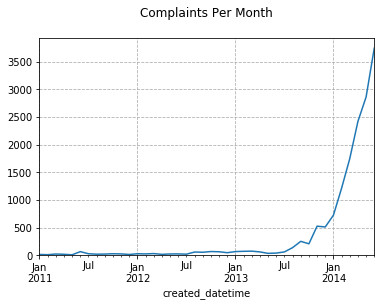

In [9]:
# Note: selecting only complaints through June 2014, the last full month with data
ax = df.loc[:"2014-06"]["company_name"].resample("M").count().plot()
ax.set_title("Complaints Per Month\n")
ax.set_ylim(0)
ax.grid(which='major', axis='both', linestyle='--')
pass

## What Types of Communication Are Scammers Using?

In [10]:
df["complaint_info_initial_contact_method"].value_counts()

Phone Call: Landline       10044
Phone                       2769
Phone Call: Mobile/Cell     2543
Internet/E-mail              226
Mobile: Text/Email/IM         58
Mail                          57
I Initiated Contact           36
Unknown                       34
Internet Web Site             30
In Person                     16
Internet (Other)              11
Wireless                       7
Fax                            3
Print                          3
TV/Radio                       1
Name: complaint_info_initial_contact_method, dtype: int64

In [11]:
# GUI Representation
contactMethodTotal ={'Contact Method':df["complaint_info_initial_contact_method"].value_counts().index.tolist(),
          'Total': df["complaint_info_initial_contact_method"].value_counts()}
df1 = pd.DataFrame(contactMethodTotal, columns = ['Contact Method', 'Total'])
df1 = df1[['Contact Method', 'Total']].groupby('Contact Method').sum()
root = Tk()
root.title('Contact Methods From Scammers')
root.geometry("1300x1600")
figure1 = mpl.pyplot.Figure(figsize=(20, 2), dpi=80)
ax1 = figure1.add_subplot(111)
bar1 = FigureCanvasTkAgg(figure1, root)
bar1.get_tk_widget().pack(side=LEFT, fill=BOTH)
df1.plot.barh(legend=False, ax=ax1, color='ybgrcm')
ax1.set_title('Contact Methods Vs. Total Scams')
    
root.mainloop()

In [12]:
# Coalesce "Phone" types
df["phone"] = df['complaint_info_initial_contact_method'].apply(lambda x: int("Phone" in str(x)))

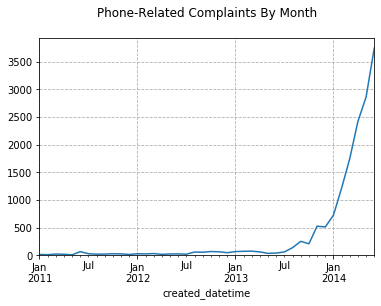

In [13]:
ax = df["phone"].loc[:"2014-06"].resample("M").count().plot()
ax.set_title("Phone-Related Complaints By Month\n")
ax.set_ylim(0)
ax.grid(which='major', axis='both', linestyle='--')
pass

## Finding the Change Over Time

The trend in the graph is obviously a huge spike. Let's look at all the months for which we have a full set of data available and see just how big the change has been over time.

In [14]:
complaints_by_month = df["reference_number"].resample("MS").count()

In [15]:
first_six_months_2011 = complaints_by_month.loc["2011-01": "2011-06"].sum()
first_six_months_2012 = complaints_by_month.loc["2012-01": "2012-06"].sum()
first_six_months_2013 = complaints_by_month.loc["2013-01": "2013-06"].sum()
first_six_months_2014 = complaints_by_month.loc["2014-01": "2014-06"].sum()

In [16]:
print("Pct. Change 2012 vs. 2011: {pct:,.2f}%".format(pct=(first_six_months_2012-first_six_months_2011)/float(first_six_months_2011)*100))
print("Pct. Change 2013 vs. 2012: {pct:,.2f}%".format(pct=(first_six_months_2013-first_six_months_2012)/float(first_six_months_2012)*100))
print("Pct. Change 2014 vs. 2013: {pct:,.2f}%".format(pct=(first_six_months_2014-first_six_months_2013)/float(first_six_months_2013)*100))

Pct. Change 2012 vs. 2011: 5.63%
Pct. Change 2013 vs. 2012: 133.33%
Pct. Change 2014 vs. 2013: 3,529.14%


In [17]:
int(first_six_months_2014/first_six_months_2013)

36

## Where Are These Phone Calls Coming From?

Washington DC's main area code — *202* — accounts for far more phone calls than any other area code.

In [18]:
df['company_phone_area_code'].value_counts().head(20)

202    6113
415    1549
585     818
888     674
206     416
530     401
347     368
800     332
866     320
716     305
877     150
844     145
571     134
213     124
917     107
876      96
516      89
425      82
646      79
253      79
Name: company_phone_area_code, dtype: int64

In [19]:
# GUI Representation
companyPhoneAreaCodeTotal ={'Company Phone Area Code':df['company_phone_area_code'].value_counts().head(20).index.tolist(),
          'Total': df['company_phone_area_code'].value_counts().head(20)}
df1 = pd.DataFrame(companyPhoneAreaCodeTotal, columns = ['Company Phone Area Code', 'Total'])
df1 = df1[['Company Phone Area Code', 'Total']].groupby('Company Phone Area Code').sum()
root = Tk()
root.title('Phone Calls by Company Phone Area Code')
root.geometry("1300x1600")
figure1 = mpl.pyplot.Figure(figsize=(20, 2), dpi=80)
ax1 = figure1.add_subplot(111)
bar1 = FigureCanvasTkAgg(figure1, root)
bar1.get_tk_widget().pack(side=LEFT, fill=BOTH)
df1.plot.bar(legend=False, ax=ax1, color='ybgrcm')
ax1.set_title('Company Phone Area Codes Vs. Total Phone Calls')
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

root.mainloop()

In [20]:
top_phone_numbers = pd.DataFrame(df.groupby(['company_phone_area_code', 'company_phone_number']).size(), columns=["complaints"])

In [21]:
top_phone_numbers.sort_values("complaints", ascending=False).head(20)

complaints
company_phone_area_code company_phone_number            
585                     6331814                      165
                        6331792                      148
415                     2514089                      131
                        2511037                      126
800                     8291040                      103
415                     2510522                       96
202                     2413122                       94
                        5069044                       89
                        2412158                       84
                        2411435                       80
415                     4848569                       78
202                     2411375                       78
347                     5597963                       78
202                     5069319                       75
347                     5590378                       71
202                     2411818                       68
                        5068708                       67
                        2807395                       66
530                     2385813                       64
206                     4144646                       60

In [22]:
df_202 = df[df["company_phone_area_code"] == "202"]

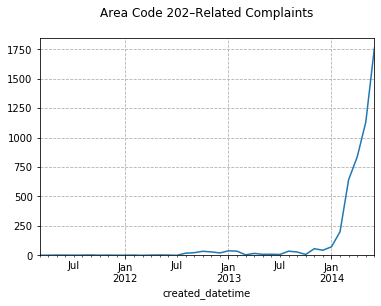

In [23]:
ax = df_202.loc[:"2014-06"]["phone"].resample("M").sum().plot()
ax.set_title(u"Area Code 202–Related Complaints\n")
ax.set_ylim(0)
ax.grid(which='major', axis='both', linestyle='--')
pass

In [24]:
df_202_by_month = df_202["reference_number"].resample("MS").count()

In [25]:
print("Area code 202 accounted for {0:,.1f}% of all complaints during the first six months of 2014"
      .format(100 * float(df_202_by_month.loc["2014-01":"2014-06"].sum()/float(first_six_months_2014))))

Area code 202 accounted for 38.9% of all complaints during the first six months of 2014


## The Most Popular States and Cities to Scam

In [26]:
df['clean_state'].dropna().value_counts().head(20)

CA    2471
NY    1189
FL     965
TX     942
NJ     663
PA     555
VA     545
IL     532
MA     503
GA     437
OH     414
AZ     413
WA     408
MD     360
MI     348
NC     339
IN     287
CO     280
OR     228
NV     223
Name: clean_state, dtype: int64

In [27]:
# GUI Representation
statesTotal ={'States':df['clean_state'].dropna().value_counts().head(20).index.tolist(),
          'Total': df['clean_state'].dropna().value_counts().head(20)}
df1 = pd.DataFrame(statesTotal, columns = ['States', 'Total'])
df1 = df1[['States', 'Total']].groupby('States').sum()
root = Tk()
root.title('The Most Popular States to Scam')
root.geometry("1300x1600")
figure1 = mpl.pyplot.Figure(figsize=(20, 2), dpi=80)
ax1 = figure1.add_subplot(111)
ax1.set_xlabel('States')
bar1 = FigureCanvasTkAgg(figure1, root)
bar1.get_tk_widget().pack(side=LEFT, fill=BOTH)
explode_largest = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df1.plot.pie(autopct='%.2f', explode=explode_largest, legend=False, subplots=True, ax=ax1, shadow=True, startangle=90)
ax1.set_title('States Vs. Total Scams')

root.mainloop()

In [28]:
df['consumer_address_city'].value_counts().head(20)

Las Vegas        130
Houston          112
New York         106
Brooklyn         103
San Jose         100
Los Angeles       95
Phoenix           86
San Diego         83
Chicago           75
San Francisco     71
Charlotte         66
Washington        66
Austin            65
Albuquerque       58
Denver            55
Tucson            53
Seattle           53
Portland          49
Indianapolis      49
Honolulu          48
Name: consumer_address_city, dtype: int64

In [29]:
# GUI Representation
citiesTotal ={'Cities':df['consumer_address_city'].value_counts().head(20).index.tolist(),
          'Total': df['consumer_address_city'].value_counts().head(20).head(20)}
df1 = pd.DataFrame(citiesTotal, columns = ['Cities', 'Total'])
df1 = df1[['Cities', 'Total']].groupby('Cities').sum()
root = Tk()
root.title('The Most Popular Cities to Scam')
root.geometry("1300x1600")
figure1 = mpl.pyplot.Figure(figsize=(20, 2), dpi=80)
ax1 = figure1.add_subplot(111)
ax1.set_xlabel('Cities')
bar1 = FigureCanvasTkAgg(figure1, root)
bar1.get_tk_widget().pack(side=LEFT, fill=BOTH)
explode_largest = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df1.plot.pie(autopct='%.2f', explode=explode_largest, legend=False, subplots=True, ax=ax1, shadow=True, startangle=90)
ax1.set_title('Cities Vs. Total Scams')

root.mainloop()

## Normalizing the 2014 Complaints by State for 2013 Population

In [30]:
state_abbreviations = pd.read_csv("state_abbreviations.csv").set_index("name")
state_populations = pd.read_csv("state_pop_2013.csv").set_index("name")

In [31]:
state_pop = state_populations.join(state_abbreviations).set_index("abbr")

In [32]:
df_2014 = df.loc["2014"]
states_2014 = pd.DataFrame(df_2014.groupby(['clean_state']).size(), columns=[ "complaints" ]).join(state_pop).dropna()

In [33]:
assert(len(states_2014) == 52) # 50 States + DC and PR

In [34]:
states_2014["complaints_per_100k"] = states_2014.apply(lambda x: round(x["complaints"] / float(x["population"]) * 100000, 1), axis=1)

In [35]:
states_2014["population"] = states_2014["population"].astype("int")

In [37]:
states_2014.sort_values("complaints_per_100k", ascending=False)

,complaints,population,complaints_per_100k
clean_state,,,
DE,83,925749,9.0
DC,50,646449,7.7
NV,197,2790136,7.1
HI,97,1404054,6.9
MA,424,6692824,6.3
NJ,555,8899339,6.2
VA,469,8260405,5.7
CA,2150,38332521,5.6
AZ,353,6626624,5.3
